In [1]:
import os
import json

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score

os.environ['CUDA_VISIBLE_DEVICES'] = '2'
# solve the problem of "libdevice not found at ./libdevice.10.bc"
os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/home/r10222035/.conda/envs/tf2'

2025-08-06 14:56:00.915164: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-06 14:56:00.983380: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


# Plot ROC curve

In [2]:
def get_sample_size(y):
    if len(y.shape) == 1:
        ns = (y == 1).sum()
        nb = (y == 0).sum()
    else:
        ns = (y.argmax(axis=1) == 1).sum()
        nb = (y.argmax(axis=1) == 0).sum()
    print(ns, nb)
    return ns, nb

In [3]:
def pt_normalization(X):
    # input shape: (n, res, res, 3)
    mean = np.mean(X, axis=(1, 2), keepdims=True)
    std = np.std(X, axis=(1, 2), keepdims=True)
    epsilon = 1e-8
    std = np.where(std < epsilon, epsilon, std)
    return (X - mean) / std

In [4]:
def get_fpr_tpr(config_path):
    # Read config file
    with open(config_path, 'r') as f:
        config = json.load(f)

    npy_path = Path(config['npy_path'])
    n_test = config['n_test']
    model_name = config['model_name']

    # Load data
    data_b = np.load(npy_path / 'GGF-data.npy', allow_pickle=True)
    data_s = np.load(npy_path / 'VBF-data.npy', allow_pickle=True)
    # Split the dataset
    X_test = np.concatenate((data_b[-n_test:], data_s[-n_test:]))
    y_test = np.concatenate((np.zeros(n_test), np.ones(n_test)))
    X_test = pt_normalization(X_test)

    # Load the model
    save_model_name = f'./CNN_models/last_model_GGF_VBF_supervised_{model_name}/'
    loaded_model = tf.keras.models.load_model(save_model_name)

    y_pred = loaded_model.predict(X_test, batch_size=512)
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    
    return fpr, tpr, auc 

2025-08-06 14:56:21.433700: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-06 14:56:22.028260: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22288 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:d8:00.0, compute capability: 8.6
2025-08-06 14:56:25.910639: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401


20/98 [=====>........................] - ETA: 0s

2025-08-06 14:56:27.519363: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


98/98 [==============================] - 1s 8ms/step


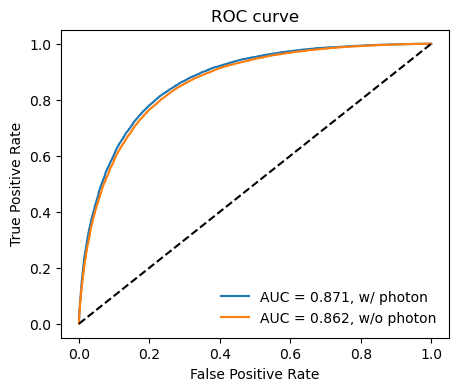

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

config_path = './config_files/supervised_pT_norm_eventCNN_config_01.json'
fpr, tpr, auc = get_fpr_tpr(config_path)
ax.plot(fpr, tpr, label=f'AUC = {auc:.3f}, w/ photon')

config_path = './config_files/supervised_pT_norm_eventCNN_remove_photon_config_01.json'
fpr, tpr, auc = get_fpr_tpr(config_path)
ax.plot(fpr, tpr, label=f'AUC = {auc:.3f}, w/o photon')

ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve')
ax.legend(frameon=False)

plt.savefig('../figures/roc_curve_supervised.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()